# Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import requests
import re
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, SimpleRNN, Activation, Embedding, Bidirectional, LSTM
import matplotlib.pyplot as plt



# Classes and Functions

In [2]:
#@ Classes

def knn():




class Train:
    def __init__(self, ds_train):
        self.df = None
        self.raw_df = None
        self.sentences = None
        self.labels = None
        self.sequences = None
        self.padded = None


        # take 10000 rows of premise and hypothesis sentences
        self.raw_df = tfds.as_dataframe(ds_train.take(10000))
        # concatenate premise and hypothesis into one sentence
        self.raw_df['premise_hyp'] = self.raw_df.apply(lambda x: conc(str(x['premise']), str(x['hypothesis'])), axis=1)
        # select only desired columns
        self.raw_df = self.raw_df[['premise_hyp', 'label']]
        self.df = self.raw_df.copy()
        # normalize sentences
        self.df['premise_hyp'] = self.df['premise_hyp'].apply(lambda x: normalizarString(x))
        self.df = self.df[self.df['label'] != -1]
        self.sentences = []
        self.labels = []
        for i, row in self.df.iterrows():
            self.sentences.append(row[0])
            self.labels.append(row[1])


class Validation:
    def __init__(self, ds_validation):
        self.df = None
        self.raw_df = None
        self.sentences = None
        self.labels = None
        self.sequences = None
        self.padded = None

        # take 10000 rows of premise and hypothesis sentences
        self.raw_df = tfds.as_dataframe(ds_validation.take(2500))

        # concatenate premise and hypothesis into one sentence
        self.raw_df['premise_hyp'] = self.raw_df.apply(lambda x: conc(str(x['premise']), str(x['hypothesis'])), axis=1)
        # select only desired columns
        self.raw_df = self.raw_df[['premise_hyp', 'label']]
        self.df = self.raw_df.copy()
        # normalize sentences
        self.df['premise_hyp'] = self.df['premise_hyp'].apply(lambda x: normalizarString(x))
        self.df = self.df[self.df['label'] != -1]

        self.sentences = []
        self.labels = []
        for i, row in self.df.iterrows():
            self.sentences.append(row[0])
            self.labels.append(row[1])


class Test:
    def __init__(self, ds_test):
        self.df = None
        self.raw_df = None
        self.sentences = None
        self.labels = None
        self.sequences = None
        self.padded = None

        # take 10000 rows of premise and hypothesis sentences
        self.raw_df = tfds.as_dataframe(ds_test.take(2500))

        # concatenate premise and hypothesis into one sentence
        self.raw_df['premise_hyp'] = self.raw_df.apply(lambda x: conc(str(x['premise']), str(x['hypothesis'])), axis=1)
        # select only desired columns
        self.raw_df = self.raw_df[['premise_hyp', 'label']]
        self.df = self.raw_df.copy()
        # normalize sentences
        self.df['premise_hyp'] = self.df['premise_hyp'].apply(lambda x: normalizarString(x))
        self.df = self.df[self.df['label'] != -1]

        self.sentences = []
        self.labels = []
        for i, row in self.df.iterrows():
            self.sentences.append(row[0])
            self.labels.append(row[1])


class HyperParameters:
    def __init__(self, vocab_size, embedding_dim, max_length, trunc_type, padding_type, epochs):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.trunc_type = trunc_type
        self.padding_type = padding_type
        self.epochs = epochs


class Models:

    def __init__(self, model_name, train, validation,test, hp):
        self.model_name = model_name
        self.hp = hp
        self.model = self.choose_model()
        self.train = train
        self.validation = validation
        self.test = test
        self.history = None
        self.metrics = {
            'accuracy': 'accuracy',
            'loss': 'loss',
        }


    def choose_model(self):
        if self.model_name == 'rnn':
            model = Sequential([
                Embedding(self.hp.vocab_size, self.hp.embedding_dim, input_length=self.hp.max_length),
                SimpleRNN(32),
                Dense(10, activation='relu'),
                Dense(1, activation='sigmoid')
            ])

            ...
            model.summary()
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model
        elif self.model_name == 'lstm':
            model = Sequential([
                Embedding(self.hp.vocab_size, self.hp.embedding_dim, input_length=self.hp.max_length),
                LSTM(32),
                Dense(10, activation='relu'),
                Dense(1, activation='sigmoid')
            ])

            ...
            model.summary()
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model

        elif self.model_name == 'bilstm':
            model = Sequential([
                Embedding(self.hp.vocab_size, self.hp.embedding_dim, input_length=self.hp.max_length),
                Bidirectional(LSTM(32)),
                Dense(10, activation='relu'),
                Dense(1, activation='sigmoid')
            ])

            ...
            model.summary()
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model


    def fit(self):
        self.history = self.model.fit(self.train.padded, self.train.labels, epochs=self.hp.epochs,
                                      validation_data=(self.validation.padded, self.validation.labels), verbose=2)

    def show_plot(self, metric):
        plt.plot(self.history.history[metric])
        plt.plot(self.history.history['val_' + metric], '')
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend([metric, 'val_' + metric])
        plt.title(self.model_name + ' ' + metric)
        plt.show()

In [3]:
#@ Auxiliary functions

def createWordIndexCustom(vocabulary):
    word_index = {}
    for word, index in vocabulary.items():
        word_index[word] = index
    return word_index


def createWordIndex(hp, train, validation, test):
    # creates word_index for vocabulary
    tokenizer = Tokenizer(num_words=hp.vocab_size)
    # fit_on_texts receives a list of sentences. Can be a series of dataframe too
    tokenizer.fit_on_texts(train.sentences)

    train.sequences = tokenizer.texts_to_sequences(train.sentences)
    validation.sequences = tokenizer.texts_to_sequences(validation.sentences)
    test.sequences = tokenizer.texts_to_sequences(test.sentences)

    #
    # max_len = len(train.sequences[0])
    # for train,valid,test in zip(train.sequences,validation.sequences,test.sequences):
    #     if max(len(train),len(valid),len(test)) > max_len:
    #         max_len = max(len(train),len(valid),len(test))



    train.padded = pad_sequences(train.sequences, maxlen=hp.max_length, padding=hp.padding_type,
                                 truncating=hp.trunc_type)
    validation.padded = pad_sequences(validation.sequences, maxlen=hp.max_length, padding=hp.padding_type,
                                      truncating=hp.trunc_type)
    test.padded = pad_sequences(test.sequences, maxlen=hp.max_length, padding=hp.padding_type, truncating=hp.trunc_type)

    train.labels = np.array(train.labels)
    validation.labels = np.array(validation.labels)
    test.labels = np.array(test.labels)




def createVocabulary(train):
    vocabulary = {}
    for i in range(0, len(train.sentences)):
        for word in train.sentences[i].split():
            if word in vocabulary:
                vocabulary[word] += 1
            else:
                vocabulary[word] = 1
    return vocabulary


def conc(x, y):
    return x + y


def normalizarString(text):
    import unicodedata

    text = text.lower()
    text = re.sub(r'(b\')|(\')', '', text)
    return text


def usingStopwords():
    master = "https://raw.githubusercontent.com/guico3lho/NLP_UnB_2022_1/main/stopwords_pt.txt"
    req = requests.get(master)
    text = req.text

    stop_words = []
    pattern = r'\n?'
    rt = re.compile(pattern)

    for i in text.split('\n'):
        stop_words.append(normalizarString(rt.sub('', i)))
    print(f'Fim do Preenchimento das stopwords')

    return stop_words


# Execution

In [5]:
stopwords = usingStopwords()
ds_train = tfds.load('snli', split='train', shuffle_files=True)
ds_validation = tfds.load('snli', split='validation', shuffle_files=False)
ds_test = tfds.load('snli', split='test', shuffle_files=False)



Fim do Preenchimento das stopwords


In [ ]:
# preparing data
train = Train(ds_train)
validation = Validation(ds_validation)
test = Test(ds_test)
print("raw df_train:")
display(train.raw_df)
print("df_train after removel of label (-2) and preprocessing")
display(train.df)

train =

In [12]:


vocabulary = createVocabulary(train)
    
hp = HyperParameters(vocab_size=len(vocabulary), embedding_dim=16, max_length=72, trunc_type='post',
                         padding_type='post', epochs=30)

createWordIndex(hp, train, validation, test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 16)            249952    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1568      
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 251,861
Trainable params: 251,861
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
312/312 - 6s - loss: 0.1441 - accuracy: 0.3262 - val_loss: -1.0309e-01 - val_accuracy: 0.3219 - 6s/epoch - 20ms/step
Epoch 2/30
312/312 - 4s - loss: 0.0366 - accuracy: 0.3

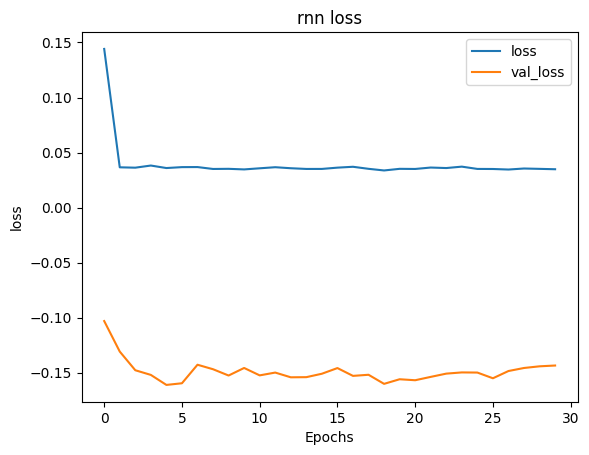

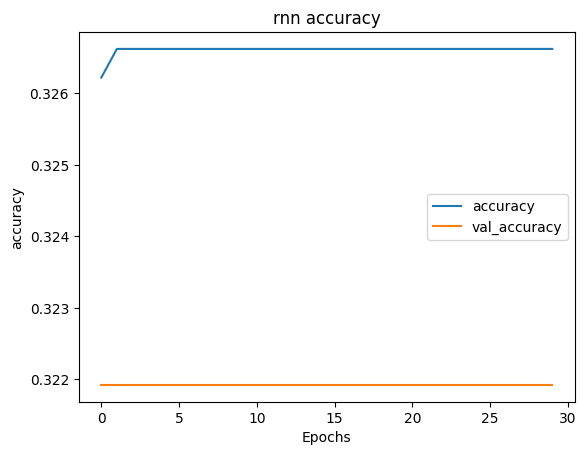

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 72, 16)            249952    
                                                                 
 lstm (LSTM)                 (None, 32)                6272      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 256,565
Trainable params: 256,565
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
312/312 - 11s - loss: 0.0828 - accuracy: 0.3266 - val_loss: -1.3288e-01 - val_accuracy: 0.3219 - 11s/epoch - 34ms/step
Epoch 2/30
312/312 - 5s - loss: 0.0376 - accuracy:

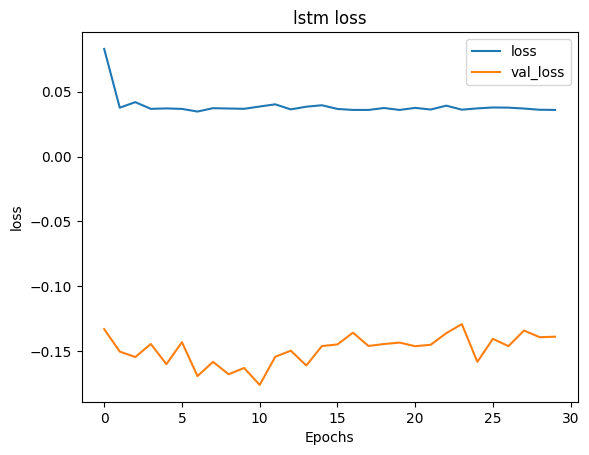

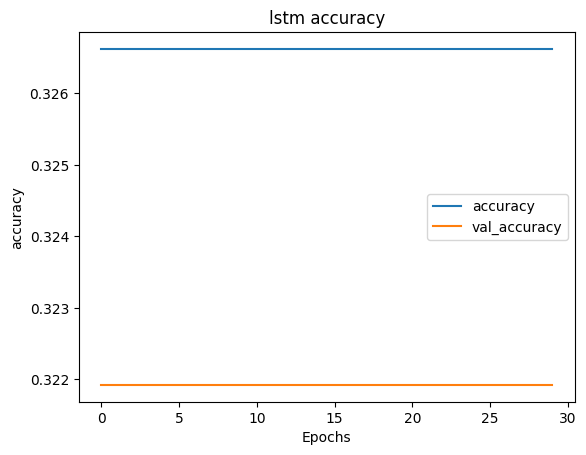

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 72, 16)            249952    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 263,157
Trainable params: 263,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
312/312 - 14s - loss: 0.0705 - accuracy: 0.3268 - val_loss: -1.7650e-01 - val_accuracy: 0.3219 - 14s/ep

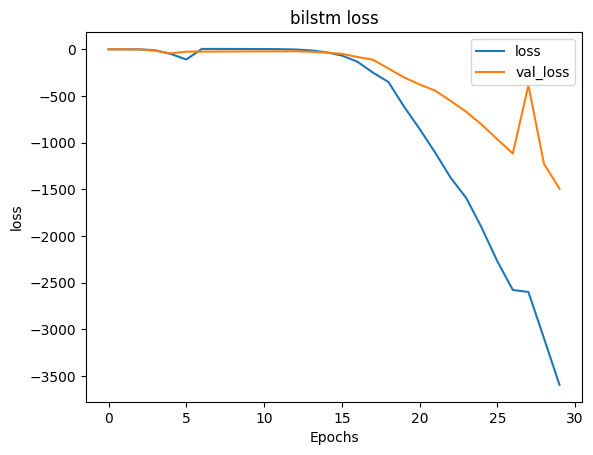

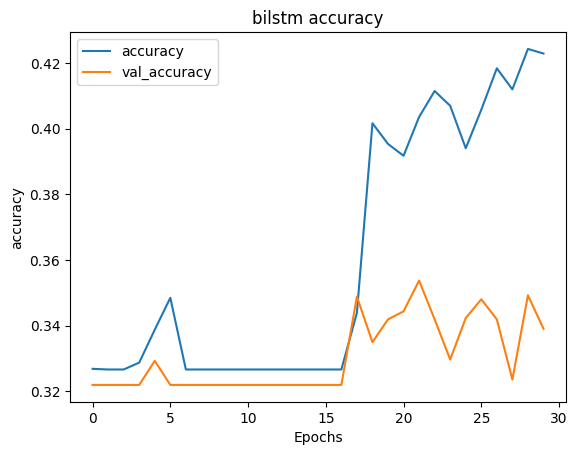

In [7]:
rnn_model = Models('rnn', train, validation, test, hp)
rnn_model.fit()
rnn_model.show_plot('loss')
rnn_model.show_plot('accuracy')

lstm_model = Models('lstm', train, validation, test, hp)
lstm_model.fit()
lstm_model.show_plot('loss')
lstm_model.show_plot('accuracy')


bilstm_model = Models('bilstm', train, validation, test, hp)
bilstm_model.fit()
bilstm_model.show_plot('loss')
bilstm_model.show_plot('accuracy')